In [2]:
import numpy as np
from scipy.io import loadmat  # this is the SciPy module that loads mat-files
import matplotlib.pyplot as plt
from datetime import datetime, date, time
import pandas as pd
from pathlib import Path  

# 1. Power Curve as per IEC 61400-12-1

In [3]:
path = r'C:\Users\Usser\Documents\MASTER_ENERGIE\OCTAVE-WIND-ENERGY\Practice_4\fichero_ws_pa10min.csv' 
df = pd.read_csv(path, header=None, names=['wind_speed','power'])

Text(0.5, 1.0, 'Power Curve')

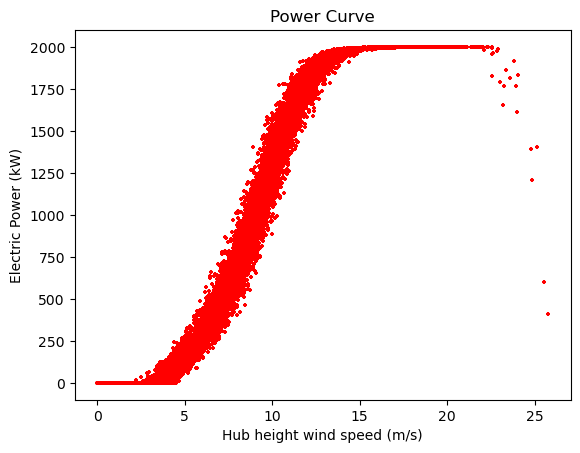

In [4]:
plt.scatter(df['wind_speed'],df['power'], c='r', marker='+', s=5)
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel("Electric Power (kW)")
plt.title("Power Curve")

## 1.1 Power curve considering a cut-in wind speed of 4 m/s

Text(0.5, 1.0, 'Power Curve')

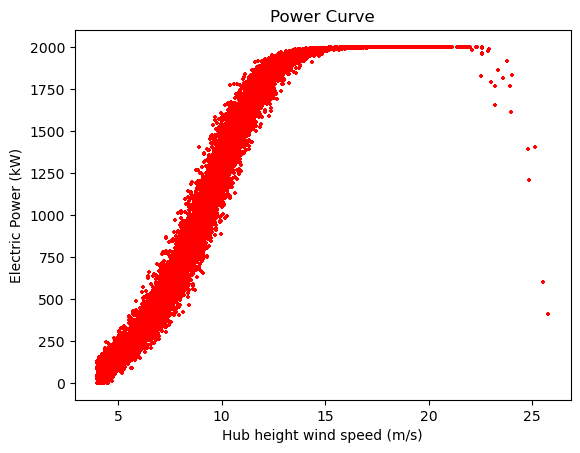

In [5]:
df_cut_in = df[df['wind_speed'] > 4.0]

plt.scatter(df_cut_in ['wind_speed'],df_cut_in['power'], c='r', marker='+', s=5)
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel("Electric Power (kW)")
plt.title("Power Curve")

## 1.2 Adjust with splines the power curve of the wind turbine

* Cover intervals from 1 m/s below the cut-in wind speed, up to 1.5 times the wind speed at 85% of the rated power.
* The wind speed range should be divided into adjacent bins of 0.5 m/s centred on multiples of 0.5 m/s.

In [6]:
wind_speed_cut_in = 4

rated_power = max(df['power'])
rated_power_at_85 = rated_power*0.85 # 85% rated power : 0.85*2000 kW = 1700 kW  

filtered_df = df[(df['power']>rated_power_at_85-5) & (df['power']<rated_power_at_85+5)] # We must find 1700 kW in a little intervale 
wind_speed_cut_off = filtered_df['wind_speed'].mean() # We find the value of the wind speed for 1700 kW (we can have severals values, we find the mean)

Text(0.5, 1.0, 'Power Curve')

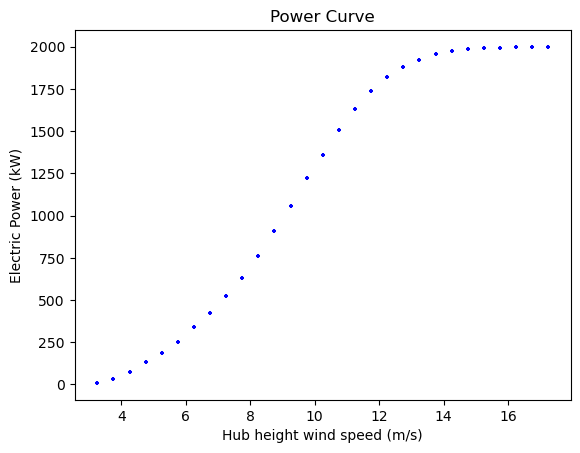

In [7]:
# Bins of wind speed range 
bins = np.arange(wind_speed_cut_in-1, np.ceil(wind_speed_cut_off*1.5),0.5)
# groups = df.groupby(['power', pd.cut(df['wind_speed'], bins)])
groups = df.groupby(pd.cut(df['wind_speed'], bins))['power'].agg(['mean', 'count'])

data = groups
data['wind_speed_mean'] = np.arange(3.25,17.5,0.5)

plt.scatter(data['wind_speed_mean'], data['mean'], c='b', marker='+', s=5)
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel("Electric Power (kW)")
plt.title("Power Curve")

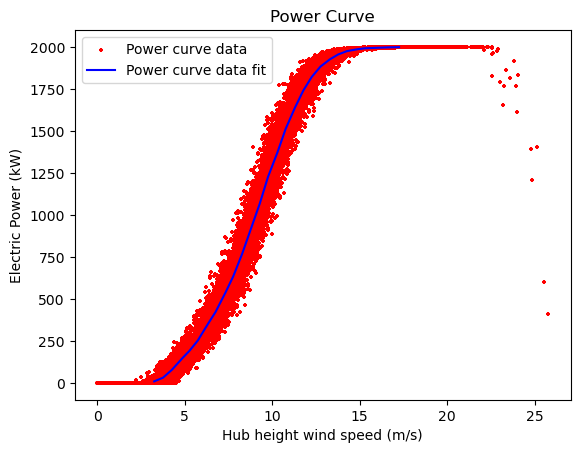

In [10]:
# Interpolation of Power Curve 
from scipy.interpolate import interp1d
xx = np.linspace(3.25,17.25,500) 
f2 = interp1d(data['wind_speed_mean'], data['mean'], kind='linear') # Interpolation by linear interpolation
# plt.scatter(df1['wind_speed_mean'], df1['power'])
# plt.scatter(df4['wind_mean'],df4['mean'], color='g')

plt.scatter(df['wind_speed'],df['power'], c='r', marker='+', s=5, label='Power curve data')
plt.plot(xx, f2(xx), color = 'b', label='Power curve data fit')
plt.title("Power Curve")
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel("Electric Power (kW)")
plt.legend()
plt.show()

# 2. Weibull distribution

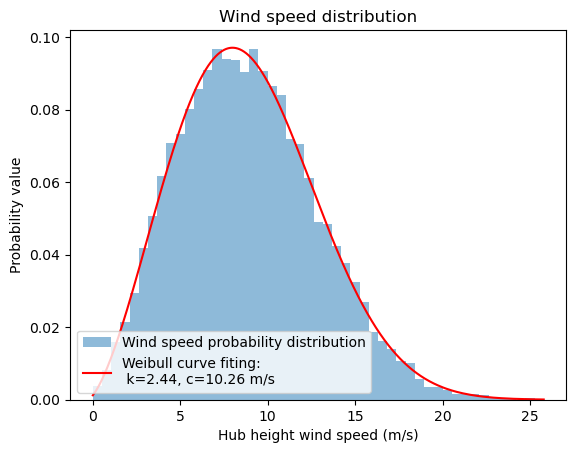

In [8]:
from scipy import stats

# Only wind speed data
ws = df['wind_speed'].sort_values(axis=0, ascending=True)

# Parameters of Weibull fir
k, b, c = stats.weibull_min.fit(ws)  

# Plot
_ = plt.hist(ws, bins=np.linspace(ws.min(), ws.max(), 50), density=True, alpha=0.5, label='Wind speed probability distribution');
plt.plot(ws, stats.exponweib.pdf(ws, *stats.exponweib.fit(ws, 1, 1, scale=2, loc=0)), c='r', label='Weibull curve fiting: \n k=%1.2f, c=%1.2f m/s' %(k, c))

plt.title('Wind speed distribution')
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel('Probability value')
plt.legend()
plt.show() 

# 3. Annual Energy Production (AEP) 

In [11]:
Nh = 8760 # Number of hours in one year
ws = df['wind_speed'].sort_values(axis=0, ascending=True)

df_energy = df.sort_values(by='wind_speed', ascending=True)
df_energy['probability'] = stats.exponweib.pdf(ws, *stats.exponweib.fit(ws, 1, 1, scale=2, loc=0))
df_energy['cumulative_probability'] = stats.exponweib.cdf(ws, *stats.exponweib.fit(ws, 1, 1, scale=2, loc=0))
df_energy_filtered =  df_energy[(df_energy['wind_speed'] > 3.25) & (df_energy['wind_speed'] < 17.25) ].reset_index(drop=True)
df_energy_filtered['power_fit'] = f2(df_energy_filtered ['wind_speed'])
df_energy_filtered['annual_energy'] = df_energy_filtered ['probability']*df_energy_filtered ['power']*Nh/10**6
df_energy_filtered['annual_energy_fit'] = df_energy_filtered ['probability']*df_energy_filtered ['power_fit']*Nh/10**6
df_energy_filtered 

,wind_speed,power,probability,cumulative_probability,power_fit,annual_energy,annual_energy_fit
0,3.251007,0.000000,0.046682,0.068724,9.318751,0.000000,0.003811
1,3.253284,0.000000,0.046721,0.068831,9.416033,0.000000,0.003854
2,3.254559,0.000000,0.046743,0.068890,9.470527,0.000000,0.003878
3,3.255083,11.588541,0.046752,0.068915,9.492904,0.004746,0.003888
4,3.255780,39.630048,0.046764,0.068947,9.522702,0.016235,0.003901
...,...,...,...,...,...,...,...
11870,17.208432,1998.446455,0.013208,0.973672,1998.647918,0.231217,0.231240
11871,17.217858,1998.671498,0.013155,0.973796,1998.664493,0.230323,0.230323
11872,17.221755,1999.778657,0.013133,0.973847,1998.671348,0.230071,0.229944
11873,17.222786,1999.343804,0.013128,0.973861,1998.673161,0.229921,0.229844


In [48]:
# AEP
Cum = 0 
for i in range(0, len(df_energy_filtered['wind_speed'])-1):
    Cum = Cum + (df_energy_filtered['cumulative_probability'][i+1]-df_energy_filtered['cumulative_probability'][i])*(df_energy_filtered['power_fit'][i+1]+df_energy_filtered['power_fit'][i])/2

aep = Cum*Nh

print('The Annual Energy Production (AEP) is: %f ' %(aep/10**6) +' GWh')

The Annual Energy Production (AEP) is: 7.908724  GWh


In [49]:
# CF 
cf = aep/(Nh*rated_power)
print('The Capacity Factor (CF) is: %f ' %(cf*100) + '%')

The Capacity Factor (CF) is: 45.139400 %


In [50]:
# EFLH
eflh = aep/rated_power
print('The Equivalent Full Load Hours (EFLH) is: %f ' %eflh) 

The Equivalent Full Load Hours (EFLH) is: 3954.211457 


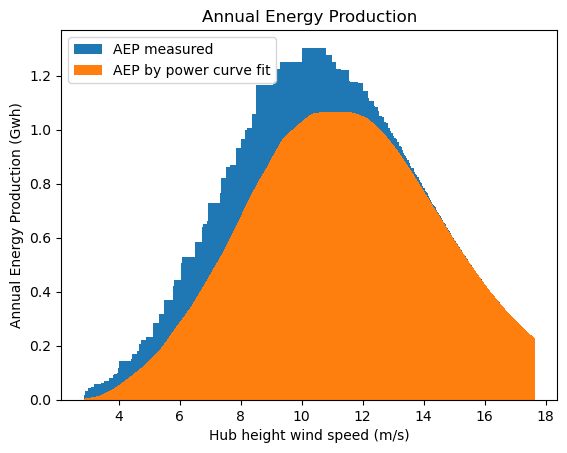

In [13]:
plt.bar(df_energy_filtered['wind_speed'], df_energy_filtered['annual_energy'], label='AEP measured')
plt.bar(df_energy_filtered['wind_speed'], df_energy_filtered['annual_energy_fit'], label='AEP by power curve fit')

plt.title('Annual Energy Production')
plt.xlabel("Hub height wind speed (m/s)")
plt.ylabel('Annual Energy Production (Gwh)')
plt.legend(loc='best')
plt.show() 

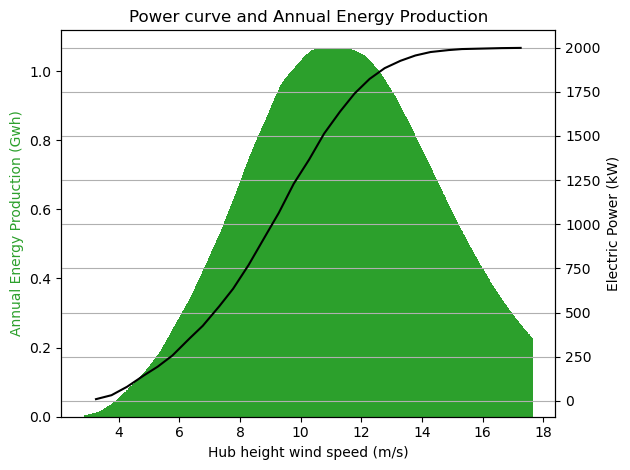

In [14]:

# Create some mock data
ws = df_energy_filtered['wind_speed']
data1 = df_energy_filtered['annual_energy_fit']
data2 = df_energy_filtered['power_fit'] 

fig = plt.figure()
ax1 = fig.add_subplot(111)

color = 'tab:green'
ax1.set_xlabel('Hub height wind speed (m/s)')
ax1.set_ylabel('Annual Energy Production (Gwh)', color=color)

# plt.hist(data1, bins=np.linspace(data2.min(), data2.max(), 50), density=True, color=color, alpha=0.5)
ax1.bar(ws, data1, color=color, label='AEP by power curve fit')
# ax1.tick_params(axis='y', labelcolor=color)
# ax1.set_ylim([0, 1.3])


ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'black'
ax2.set_ylabel('Electric Power (kW)', color=color)  # we already handled the x-label with ax1
ax2.plot(ws, data2, color=color)
# ax2.tick_params(axis='y', labelcolor=color)
# ax2.set_ylim([0, 2100])
# ax2.grid(None)
plt.title('Power curve and Annual Energy Production')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.grid()
plt.show()